# 장애인콜택시 대기시간 예측
## 단계1.데이터 전처리

## 0.미션

* 1.데이터를 탐색하며 정보 획득
    * 데이터는 2015-01-01 ~ 2022-12-31 까지의 서울 장애인 콜택시 운행 정보입니다. 우리는 평균대기시간을 예측하고자 합니다. 
    * 요일, 월, 계절, 연도별 운행 정보에 어떤 주기와 변화가 있는지 탐색해 봅시다.
* 2.분석을 위한 데이터 구조 만들기
    * 문제정의 : 
        * 전 날 콜택시 운행이 종료되었을 때, 다음 날 대기시간을 예측하고자 합니다.

        * 만약 다음 날 대기시간을 예측할 수 있다면, 일정 범위 내에서 배차를 조절할 수 있을 뿐만 아니라, 향후 교통약자의 이동 편의 증진을 위한 정책 수립 및 개선에 기여할 수 있습니다. 
    * 이를 위한 데이터 구조를 만들어 봅시다.
        * 분석 단위는 일별 데이터 입니다.
        * 주어진 데이터 : 장애인 콜택시 운행 정보, 서울시 날씨
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전 날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
        * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙여서 만듭시다.
        * 휴무일 데이터는 패키지를 통해서 다운받아 사용합니다.
    * Feature Engineering
        * 대기시간에 영향을 주는 요인을 도출하고(가설수립) 이를 feature로 생성합시다.
        * 주어진 그대로의 데이터가 아닌 새로운 feature를 생성해 봅시다.
            * 날짜와 관련된 feature : 요일, 월, 계절 ... 
            * 시계열 특성이 반영된 feature : 최근 7일간의 평균 대기시간 ...




## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
            * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 설치 및 로딩
        * requirements.txt 파일로 부터 라이브러리 설치
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다. 
        * 필요하다고 판단되는 라이브러리를 추가하세요.

### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [ ]:
path = ''

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 설치 및 불러오기

#### 1) 설치

* requirements.txt 파일을 아래 위치에 두고 다음 코드를 실행하시오.
    * 로컬 : 다음 코드셀 실행
    * 구글콜랩 : requirements.txt 파일을 왼쪽 [파일]탭에 복사해 넣고 다음 코드셀 실행

In [ ]:
!pip install -r requirements.txt

#### 2) 라이브러리 로딩

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import joblib

# 더 필요한 라이브러리를 아래에 추가합니다.
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

### (3) 데이터 불러오기
* 주어진 데이터셋
    * 장애인 콜택시 운행 정보 : open_data.csv
    * 날씨 데이터 : weather.csv

#### 1) 데이터로딩

In [3]:
file1 = 'open_data.csv'
file2 = 'weather.csv'

In [4]:
# read_csv를 활용
data = pd.read_csv(file1)
weather = pd.read_csv(file2)

In [5]:
display(data.head())
display(weather.head())

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14


In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             4018 non-null   object 
 1   temp_max         4018 non-null   float64
 2   temp_min         4018 non-null   float64
 3   rain(mm)         4018 non-null   float64
 4   humidity_max(%)  4018 non-null   float64
 5   humidity_min(%)  4018 non-null   float64
 6   sunshine(MJ/m2)  4018 non-null   float64
dtypes: float64(6), object(1)
memory usage: 219.9+ KB


In [8]:
# to_datetime 활용, '기준일' 컬럼 타입 변경  
data['기준일'] = pd.to_datetime(data['기준일'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     2922 non-null   datetime64[ns]
 1   차량운행    2922 non-null   int64         
 2   접수건     2922 non-null   int64         
 3   탑승건     2922 non-null   int64         
 4   평균대기시간  2922 non-null   float64       
 5   평균요금    2922 non-null   int64         
 6   평균승차거리  2922 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 159.9 KB


#### 2) 기본 정보 조회

In [9]:
#전체 데이터의 행,열 개수 확인
data.shape

(2922, 7)

In [10]:
#전체 데이터의 모든 변수 확인
data.head()

,기준일,차량운행,접수건,탑승건,평균대기시간,평균요금,평균승차거리
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


#### 3) 칼럼이름을 영어로 변경
* 꼭 필요한 작업은 아니지만, 데이터를 편리하게 다루고 차트에서 불필요한 경고메시지를 띄우지 않게 하기 위해 영문으로 변경하기를 권장합니다.

In [11]:
# 컬럼 명으로 'Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance' 추천
data.columns = ['Date','car_cnt','request_cnt','ride_cnt','waiting_time','fare','distance']
data.head()


,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance
0,2015-01-01,213,1023,924,23.2,2427,10764
1,2015-01-02,420,3158,2839,17.2,2216,8611
2,2015-01-03,209,1648,1514,26.2,2377,10198
3,2015-01-04,196,1646,1526,24.5,2431,10955
4,2015-01-05,421,4250,3730,26.2,2214,8663


## 2.데이터 기본 탐색

* **세부요구사항**
    * 날짜 요소에 따라 각 정보의 패턴을 조회 합니다.
        * 일별, 요일별, 주차별, 월별, 연도별
        * 접수건, 탑승건, 거리, 요금, 대기시간 등
    * 제시된 범위 외에 가능하다면 추가 탐색을 시도합니다.

### (1) 주기별 분석을 위해서 날짜 변수 추가하기
* data를 복사합니다.
* 복사한 df에 요일, 주차, 월, 연도 등을 추가합니다.

In [12]:
df = data.copy()

In [33]:
# dt.weekday, dt.month, dt.week, dt.year 활용
df['month'] = df.Date.dt.month
df['week'] = df.Date.dt.week
df['year'] = df.Date.dt.year
df['weekday'] = df.Date.dt.weekday
df.head()

C:\Users\user\AppData\Local\Temp\ipykernel_10356\3656241798.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week'] = df.Date.dt.week


,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0


### (2) 일별 (lineplot 활용)

* 차량 운행수

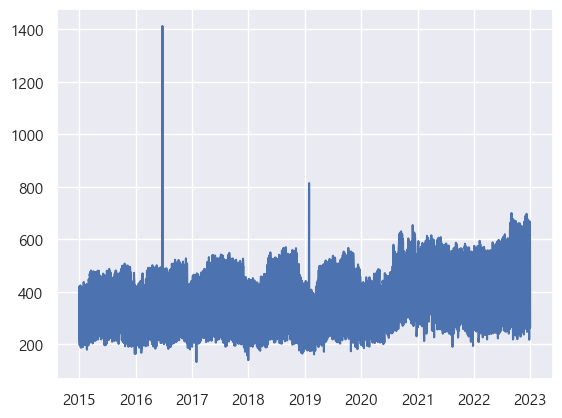

In [20]:
plt.plot(df['Date'], df['car_cnt'])
plt.show()

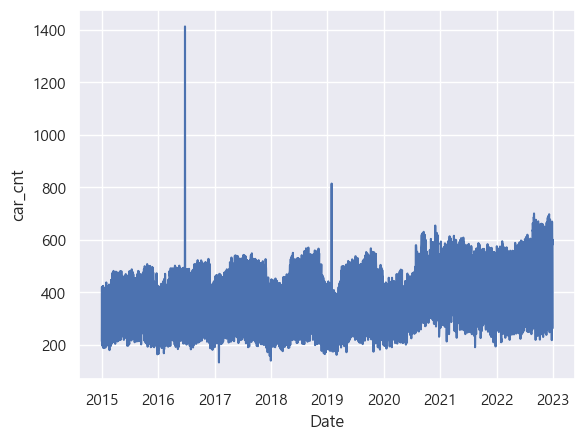

In [141]:
sns.lineplot(x='Date', y='car_cnt', data=df)
plt.show()

* 접수건, 탑승건

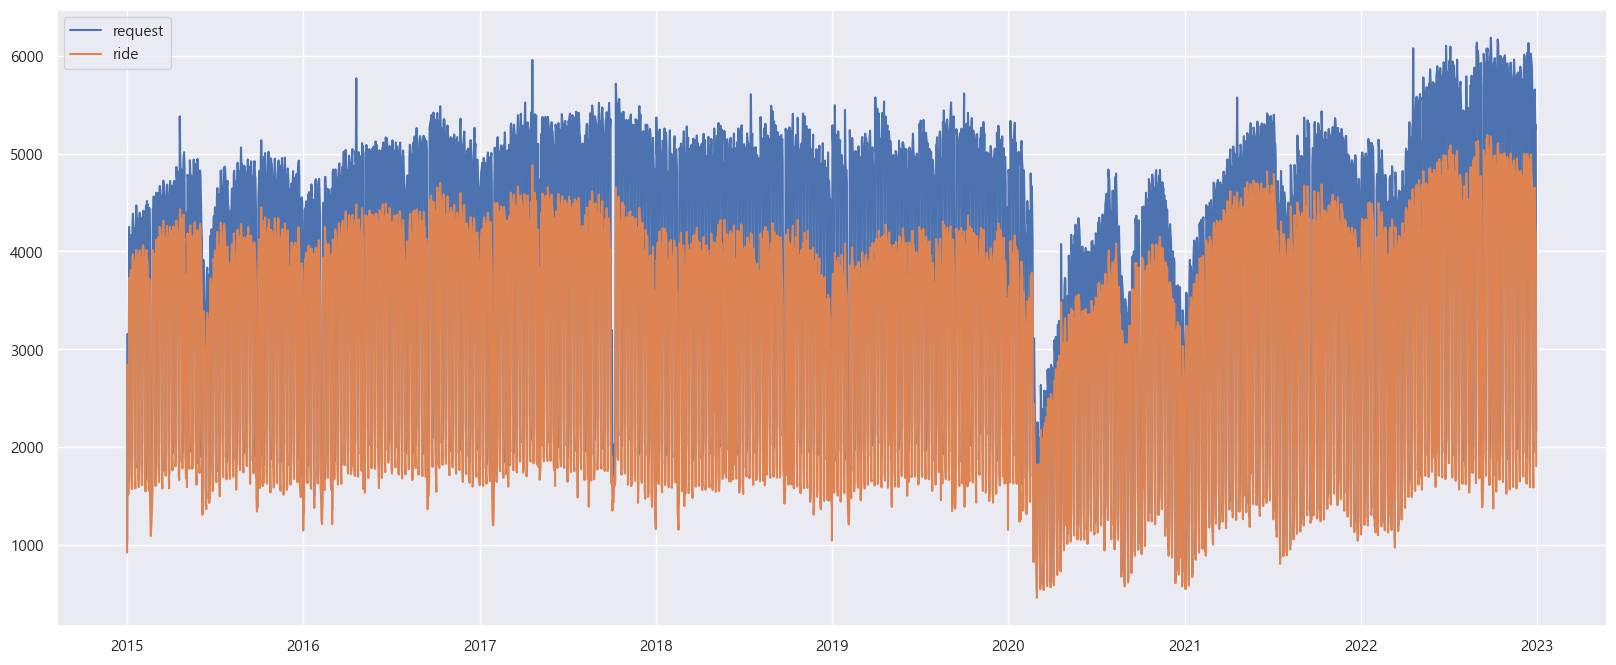

In [22]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['request_cnt'])
plt.plot(df['Date'], df['ride_cnt'])
plt.legend(['request', 'ride'])
plt.show()

* 대기시간

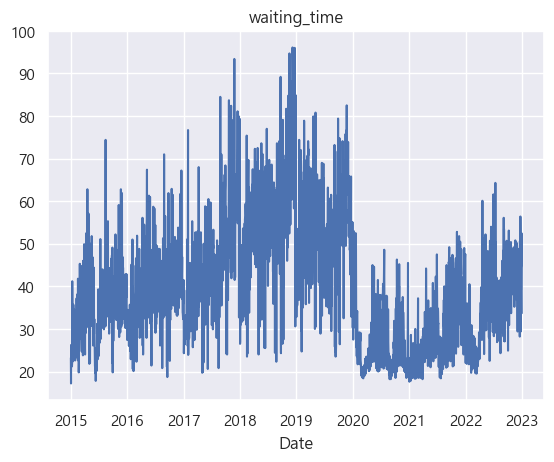

In [26]:
plt.plot(df['Date'], df['waiting_time'])
plt.xlabel('Date')
plt.title('waiting_time')
plt.show()

* 운임

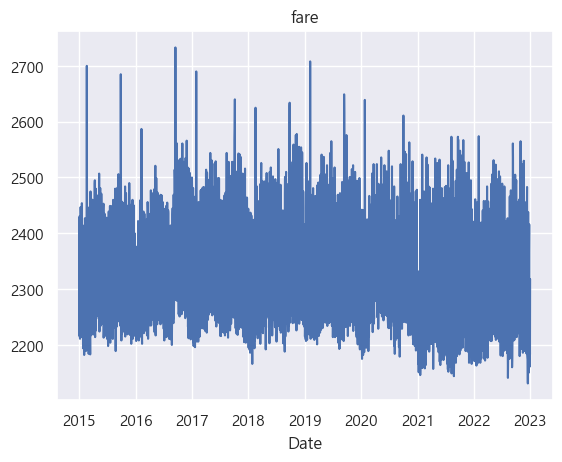

In [29]:
plt.plot(df['Date'], df['fare'])
plt.xlabel('Date')
plt.title('fare')
plt.show()

* 이동거리

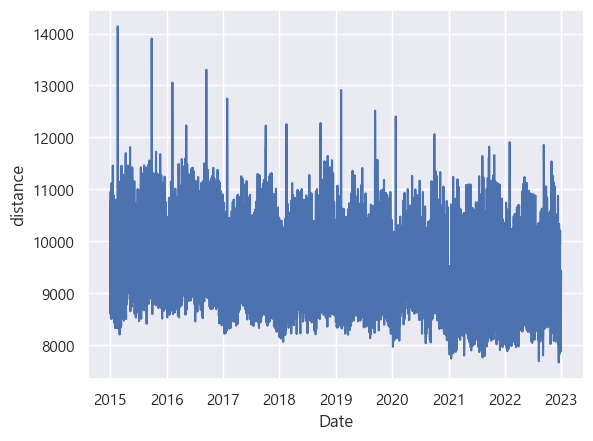

In [32]:
plt.plot(df['Date'], df['distance'])
plt.xlabel('Date')
plt.ylabel('distance')
plt.show()

### (3) 요일별 (boxplot활용)

* 차량 운행수

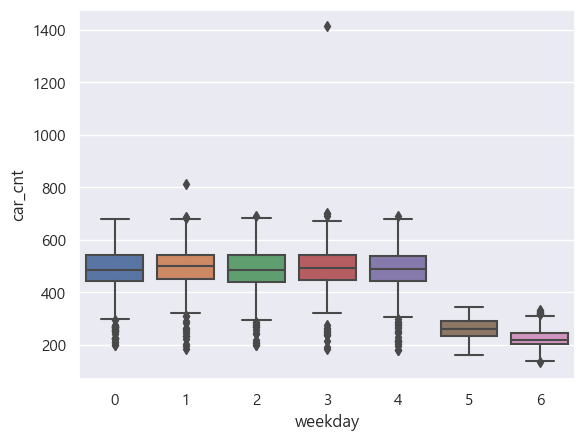

In [35]:
sns.boxplot(x='weekday', y='car_cnt', data=df)
plt.show()

* 접수건, 탑승건

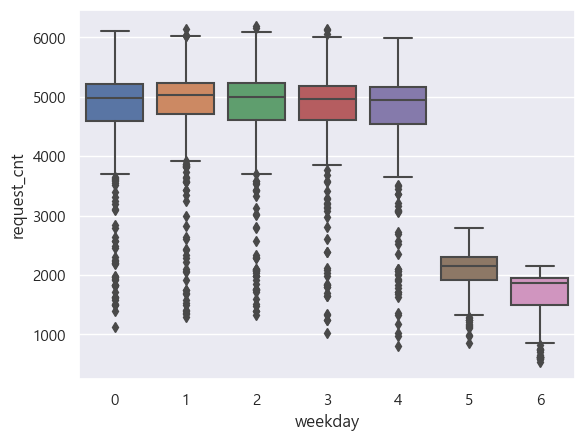

In [36]:
sns.boxplot(x='weekday', y='request_cnt', data=df)
plt.show()

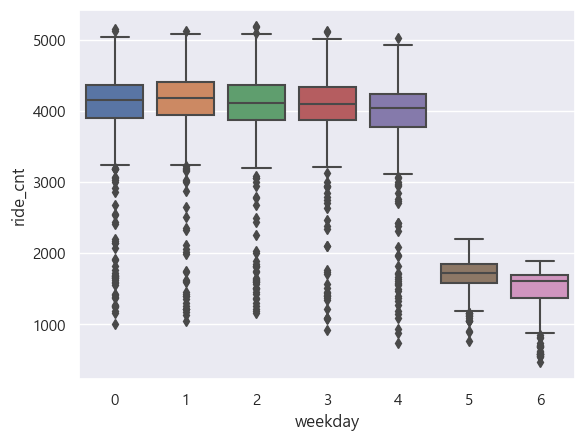

In [37]:
sns.boxplot(x='weekday', y='ride_cnt', data=df)
plt.show()

* 대기시간

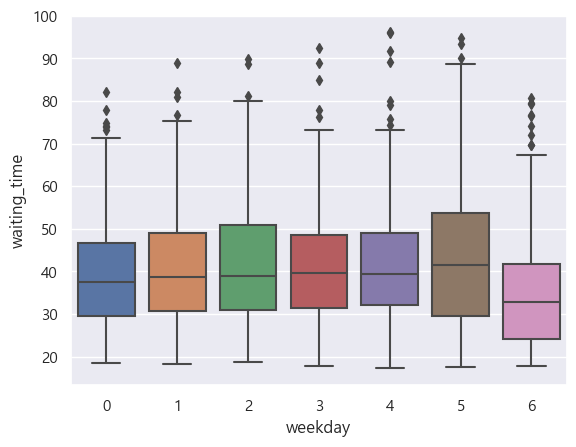

In [38]:
sns.boxplot(x='weekday', y='waiting_time', data=df)
plt.show()

* 운임

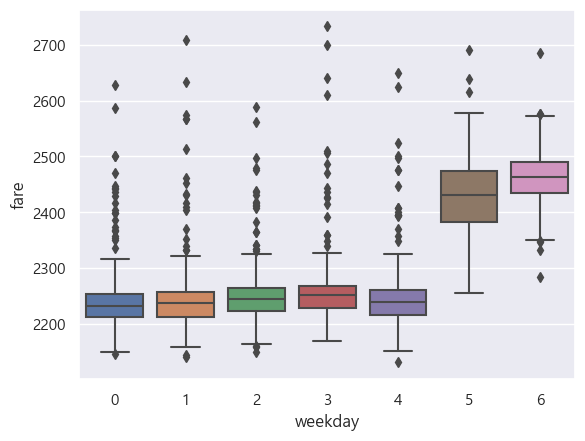

In [39]:
sns.boxplot(x='weekday', y='fare', data=df)
plt.show()

* 이동거리

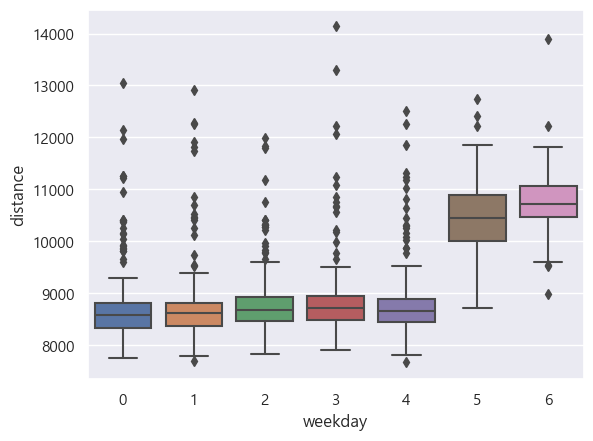

In [40]:
sns.boxplot(x='weekday', y='distance', data=df)
plt.show()

In [ ]:
# 거리와 운임은 같은 맥락(단변량 분석을 했을 때, 추세가 비슷함. -> 이유 확인, 다중공선성 문제를 해결하기 위해 제거)
# 운임은 키로당 가격이라 부정확 거리가 더 자세한 정보

### (4) 월별 (boxplot활용)

* 차량 운행수

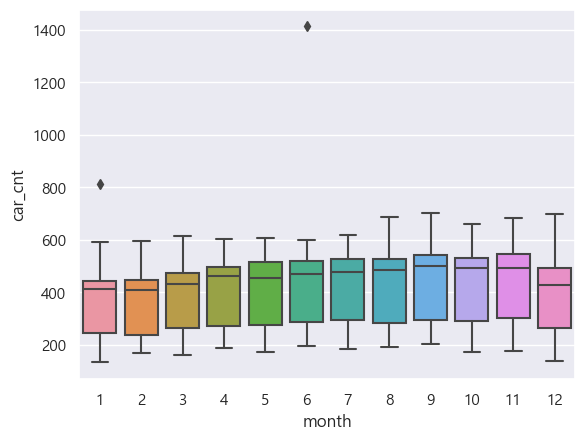

In [41]:
sns.boxplot(x='month', y='car_cnt', data=df)
plt.show()

* 접수건, 탑승건

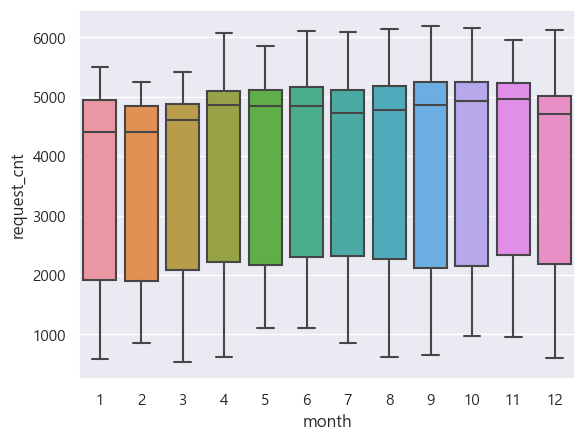

In [42]:
sns.boxplot(x='month', y='request_cnt', data=df)
plt.show()

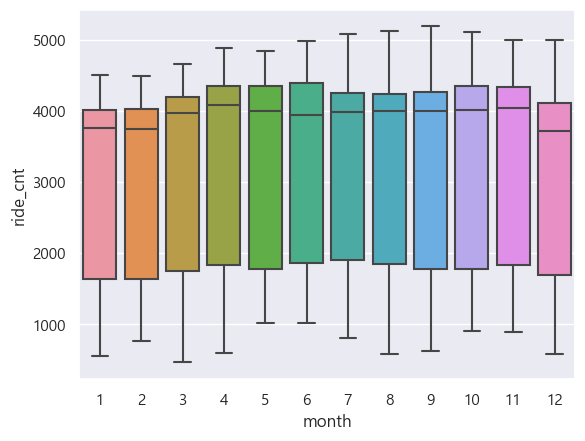

In [44]:
sns.boxplot(x='month', y='ride_cnt', data=df)
plt.show()

* 대기시간

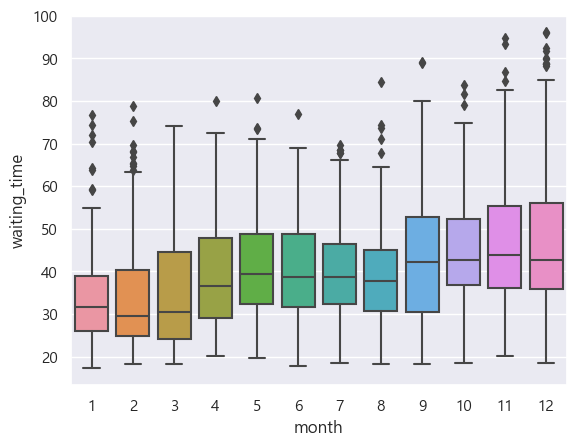

In [45]:
sns.boxplot(x='month', y='waiting_time', data=df)
plt.show()

* 운임

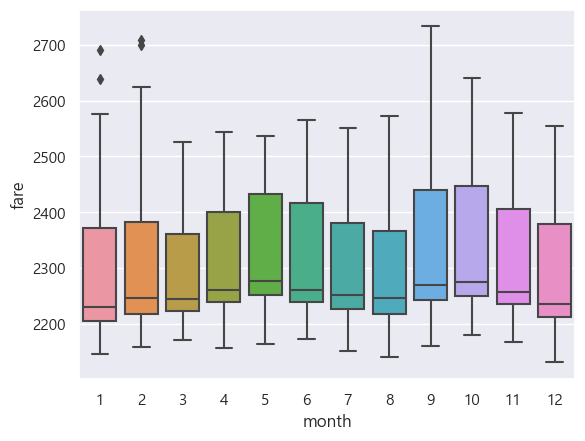

In [46]:
sns.boxplot(x='month', y='fare', data=df)
plt.show()

* 이동거리

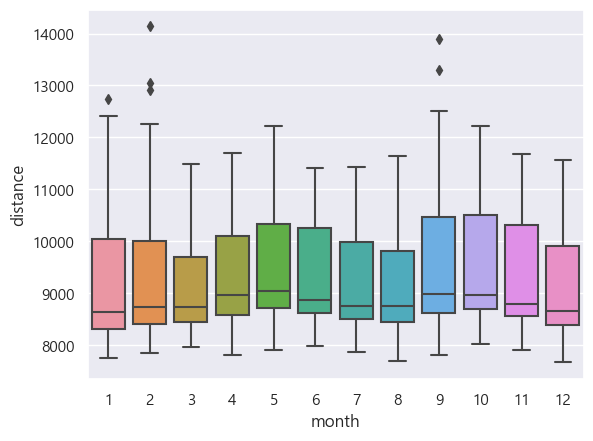

In [47]:
sns.boxplot(x='month', y='distance', data=df)
plt.show()

### (5) 연도별 (boxplot 활용)

* 차량 운행수

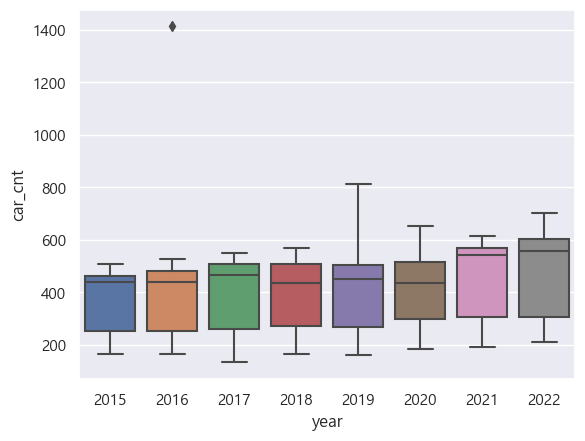

In [48]:
sns.boxplot(x='year', y='car_cnt', data=df)
plt.show()

* 접수건, 탑승건

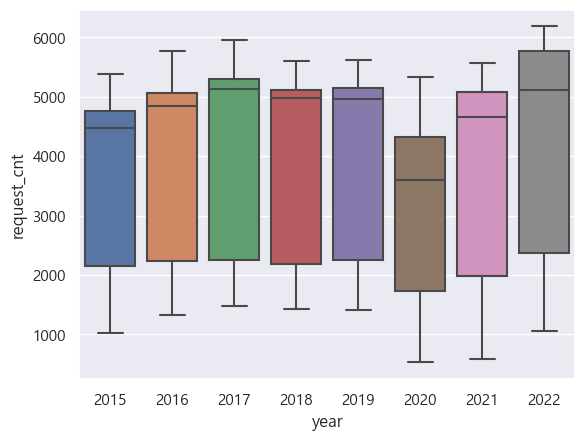

In [49]:
sns.boxplot(x='year', y='request_cnt', data=df)
plt.show()

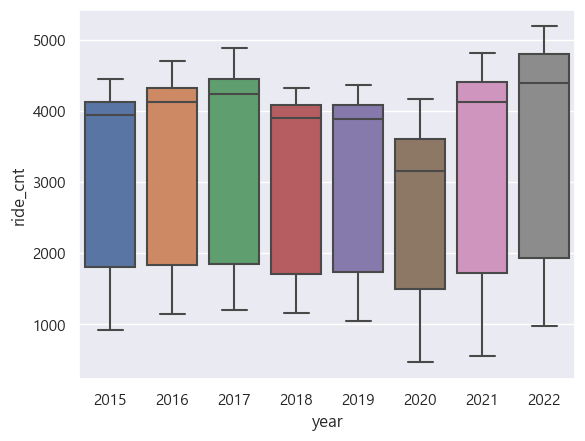

In [50]:
sns.boxplot(x='year', y='ride_cnt', data=df)
plt.show()

## 3.데이터 구조 만들기

* **세부요구사항**
    * 조건 : 
        * 목표 : 전날 저녁, 다음날 평균 대기시간을 예측하고자 합니다.
        * 날씨 데이터는 실제 측정값이지만, 다음 날에 대한 예보 데이터로 간주합니다. 
            * 예를 들어, 
                * 2020-12-23 의 날씨 데이터는 전날(12월22일) 날씨예보 데이터로 간주하여 분석을 수행합니다.
                * 2020-12-22일의 장애인 이동 데이터로 23일의 대기시간을 예측해야 하며, 이때 고려할 날씨데이터는 23일 데이터 입니다.
    * 장애인 이동 데이터를 기준으로 날씨 데이터를 붙입니다.

In [51]:
weather.head()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2)
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46
3,2012-01-04,-4.6,-9.5,0.0,66.0,38.0,8.05
4,2012-01-05,-1.4,-9.6,0.0,71.0,28.0,9.14


In [52]:
weather['Date'] = pd.to_datetime(weather['Date'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4018 non-null   datetime64[ns]
 1   temp_max         4018 non-null   float64       
 2   temp_min         4018 non-null   float64       
 3   rain(mm)         4018 non-null   float64       
 4   humidity_max(%)  4018 non-null   float64       
 5   humidity_min(%)  4018 non-null   float64       
 6   sunshine(MJ/m2)  4018 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 219.9 KB


In [55]:
weather[['temp_max_lag1', 'temp_min_lag1']] = weather[['temp_max', 'temp_min']].shift(-1)
weather.head(2)

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),temp_max_lag1,temp_min_lag1
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90,-1.2,-8.3
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16,-0.4,-6.6


In [56]:
weather.columns

Index(['Date', 'temp_max', 'temp_min', 'rain(mm)', 'humidity_max(%)',
       'humidity_min(%)', 'sunshine(MJ/m2)', 'temp_max_lag1', 'temp_min_lag1'],
      dtype='object')

In [57]:
cols = ['rain(mm)_lag_1', 'humidity_max(%)_lag_1','humidity_min(%)_lag_1', 'sunshine(MJ/m2)_lag_1']
weather[cols] = weather[['rain(mm)', 'humidity_max(%)','humidity_min(%)', 'sunshine(MJ/m2)']].shift(-1)

In [59]:
weather.head(3)

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
0,2012-01-01,0.4,-6.6,0.0,77.0,45.0,4.90,-1.2,-8.3,0.0,80.0,48.0,6.16
1,2012-01-02,-1.2,-8.3,0.0,80.0,48.0,6.16,-0.4,-6.6,0.4,86.0,45.0,4.46
2,2012-01-03,-0.4,-6.6,0.4,86.0,45.0,4.46,-4.6,-9.5,0.0,66.0,38.0,8.05


In [63]:
weather.tail()

,Date,temp_max,temp_min,rain(mm),humidity_max(%),humidity_min(%),sunshine(MJ/m2),temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
4013,2022-12-27,3.0,-7.3,0.0,86.0,51.0,10.25,-0.3,-5.4,0.1,92.0,40.0,10.86
4014,2022-12-28,-0.3,-5.4,0.1,92.0,40.0,10.86,1.7,-7.8,0.0,71.0,34.0,10.88
4015,2022-12-29,1.7,-7.8,0.0,71.0,34.0,10.88,2.1,-4.0,0.0,87.0,38.0,10.84
4016,2022-12-30,2.1,-4.0,0.0,87.0,38.0,10.84,-4.4,-4.4,0.0,66.0,66.0,0.00
4017,2022-12-31,-4.4,-4.4,0.0,66.0,66.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
weather_pre = weather[['Date', 'temp_max_lag1', 'temp_min_lag1','rain(mm)_lag_1', 'humidity_max(%)_lag_1','humidity_min(%)_lag_1', 'sunshine(MJ/m2)_lag_1']]
weather_pre.head()

,Date,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
0,2012-01-01,-1.2,-8.3,0.0,80.0,48.0,6.16
1,2012-01-02,-0.4,-6.6,0.4,86.0,45.0,4.46
2,2012-01-03,-4.6,-9.5,0.0,66.0,38.0,8.05
3,2012-01-04,-1.4,-9.6,0.0,71.0,28.0,9.14
4,2012-01-05,1.3,-4.8,0.0,55.0,27.0,8.57


In [62]:
weather_pre.tail()

,Date,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
4013,2022-12-27,-0.3,-5.4,0.1,92.0,40.0,10.86
4014,2022-12-28,1.7,-7.8,0.0,71.0,34.0,10.88
4015,2022-12-29,2.1,-4.0,0.0,87.0,38.0,10.84
4016,2022-12-30,-4.4,-4.4,0.0,66.0,66.0,0.00
4017,2022-12-31,NaN,NaN,NaN,NaN,NaN,NaN


### (1) target 만들기
* 예측하는 날짜, 대기시간(target)으로 기준을 잡습니다.

In [65]:
# 익일의 대기시간(waiting time)을 오늘의 데이터를 활용하여 예측 해야하는 대상(target)으로 설정
df['target'] = df['waiting_time'].shift(-1)
df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6


### (2) 날씨 데이터 붙이기
* merge를 활용합니다. 기준은 운행정보 입니다.

In [66]:
# 익일의 실제 날씨 데이터를 전일에 발표된 예보데이터로 판단
all_df = pd.merge(df, weather_pre)
all_df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47


In [67]:
all_df.tail(3)

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
2919,2022-12-29,581,5250,4247,52.5,2229,8433,12,52,2022,3,38.3,2.1,-4.0,0.0,87.0,38.0,10.84
2920,2022-12-30,600,5293,4200,38.3,2183,8155,12,52,2022,4,33.7,-4.4,-4.4,0.0,66.0,66.0,0.00
2921,2022-12-31,263,2167,1806,33.7,2318,9435,12,52,2022,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
all_df_copy = all_df.copy()

In [69]:
all_df.dropna(axis=0, inplace=True)
all_df.tail(3)

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1
2918,2022-12-28,607,5654,4648,44.8,2161,7882,12,52,2022,2,52.5,1.7,-7.8,0.0,71.0,34.0,10.88
2919,2022-12-29,581,5250,4247,52.5,2229,8433,12,52,2022,3,38.3,2.1,-4.0,0.0,87.0,38.0,10.84
2920,2022-12-30,600,5293,4200,38.3,2183,8155,12,52,2022,4,33.7,-4.4,-4.4,0.0,66.0,66.0,0.00


### (3) 새로운 feature를 생성해 봅시다.
* 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 그외 새로운 feature 도출 : 최소 2개 이상
    * 예 : 공휴일, 최근 7주일간의 평균 대기시간, 탑승률 등

#### 1) 날짜와 관련된 변수 추가하기 : 요일, 월, 계절, 연도
* 요일 이름, 계절이름, 월 이름으로 만드는 경우에는, 변수를 pd.Categorical로 범주형을 만들면서 순서를 지정하는 것이 이후 그래프를 그릴 때 순서대로 표현할 수 있습니다.


In [79]:
def get_season(month):
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'autumn'
    else:
        return 'winter'

In [80]:
all_df['season'] = all_df['month'].apply(lambda x :get_season(x))
all_df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter


In [81]:
all_df['season'] = pd.Categorical(all_df['season'], categories=['spring','summer','autumn','winter'], ordered=True)
all_df.head(3)

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter


In [73]:
all_df['month'] = pd.Categorical(all_df['month'], categories=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], ordered=True)
all_df.head(3)

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,겨울
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,겨울


In [74]:
all_df['weekday'] = pd.Categorical(all_df['weekday'], categories=[0, 1, 2, 3, 4, 5, 6], ordered=True)

In [77]:
all_df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,겨울
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,겨울
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,겨울
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,겨울
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,겨울


In [82]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2921 entries, 0 to 2920
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   2921 non-null   datetime64[ns]
 1   car_cnt                2921 non-null   int64         
 2   request_cnt            2921 non-null   int64         
 3   ride_cnt               2921 non-null   int64         
 4   waiting_time           2921 non-null   float64       
 5   fare                   2921 non-null   int64         
 6   distance               2921 non-null   int64         
 7   month                  2921 non-null   category      
 8   week                   2921 non-null   int64         
 9   year                   2921 non-null   int64         
 10  weekday                2921 non-null   category      
 11  target                 2921 non-null   float64       
 12  temp_max_lag1          2921 non-null   float64       
 13  tem

#### 2) 공휴일 정보
* workalendar 패키지를 설치하고, 대한민국 공휴일 정보를 끌어와 봅시다.

* 휴무일 데이터 패키지 설치

In [75]:
!pip install workalendar

                                              0.0/210.7 kB ? eta -:--:--
     -----                                 30.7/210.7 kB 660.6 kB/s eta 0:00:01
     -------------                           71.7/210.7 kB 1.3 MB/s eta 0:00:01
     ---------------------------            153.6/210.7 kB 1.1 MB/s eta 0:00:01
     ---------------------------            153.6/210.7 kB 1.1 MB/s eta 0:00:01
     ---------------------------            153.6/210.7 kB 1.1 MB/s eta 0:00:01
     ----------------------------------   204.8/210.7 kB 734.2 kB/s eta 0:00:01
     ------------------------------------ 210.7/210.7 kB 713.2 kB/s eta 0:00:00
                                              0.0/47.9 kB ? eta -:--:--
     ---------------------------------------- 47.9/47.9 kB 2.4 MB/s eta 0:00:00
                                              0.0/341.8 kB ? eta -:--:--
     ---------                               81.9/341.8 kB 2.2 MB/s eta 0:00:01
     ---------------------------            245.8/341.8 kB 3.0

* 간단 사용법

In [76]:
from workalendar.asia import SouthKorea
cal = SouthKorea()
pd.DataFrame(cal.holidays(2023))

,0,1
0,2023-01-01,New year
1,2023-01-21,Korean New Year's Day
2,2023-01-22,Korean New Year's Day
3,2023-01-23,Korean New Year's Day
4,2023-03-01,Independence Day
5,2023-05-05,Children's Day
6,2023-05-26,Buddha's Birthday
7,2023-06-06,Memorial Day
8,2023-08-15,Liberation Day
9,2023-09-28,Midautumn Festival


* 휴무일 데이터셋 만들기 2015 ~ 2022
* 실제로 휴무일에 해당하지만 workalendar 라이브러리에 없는 날짜는 직접 추가해봅시다.
    * 휴무일 장애인 콜택시의 접수건 변화에 대한 특징을 찾아 이를 바탕으로 데이터를 조회하여 찾아볼 수 있음

In [87]:
all_holidays = pd.DataFrame()

# 2015년부터 2022년까지의 공휴일 데이터를 따로 가져와서 데이터프레임에 추가
for year in range(2015, 2023):
    cal = SouthKorea()
    holidays_df = pd.DataFrame(cal.holidays(year), columns=['날짜', '공휴일'])
    all_holidays = pd.concat([all_holidays, holidays_df], ignore_index=True)

# 결과 출력
(all_holidays)

,날짜,공휴일
0,2015-01-01,New year
1,2015-02-18,Korean New Year's Day
2,2015-02-19,Korean New Year's Day
3,2015-02-20,Korean New Year's Day
4,2015-03-01,Independence Day
...,...,...
115,2022-09-10,Midautumn Festival
116,2022-09-11,Midautumn Festival
117,2022-10-03,National Foundation Day
118,2022-10-09,Hangul Day


In [111]:
all_holidays[30:50]

,Date,holidays
30,2017-01-01,New year
31,2017-01-27,Korean New Year's Day
32,2017-01-28,Korean New Year's Day
33,2017-01-29,Korean New Year's Day
34,2017-03-01,Independence Day
35,2017-05-03,Buddha's Birthday
36,2017-05-05,Children's Day
37,2017-06-06,Memorial Day
38,2017-08-15,Liberation Day
39,2017-10-03,Midautumn Festival


In [90]:
all_holidays.columns = ['Date','holidays']

,Date,holidays
0,2015-01-01,New year


In [91]:
all_holidays['Date'] = pd.to_datetime(all_holidays['Date'])
all_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      120 non-null    datetime64[ns]
 1   holidays  120 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 2.0+ KB


* 기존 데이터에 휴무일 정보 결합하기.
* 휴무일이 아닌 날짜는 0으로 저장하시오.

In [88]:
all_df_copy = all_df.copy()

In [102]:
all_df = all_df_copy.copy()
all_df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter


In [103]:
all_df.tail()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season
2916,2022-12-26,603,5555,4605,39.2,2163,7889,12,52,2022,0,44.4,3.0,-7.3,0.0,86.0,51.0,10.25,winter
2917,2022-12-27,669,5635,4654,44.4,2198,8178,12,52,2022,1,44.8,-0.3,-5.4,0.1,92.0,40.0,10.86,winter
2918,2022-12-28,607,5654,4648,44.8,2161,7882,12,52,2022,2,52.5,1.7,-7.8,0.0,71.0,34.0,10.88,winter
2919,2022-12-29,581,5250,4247,52.5,2229,8433,12,52,2022,3,38.3,2.1,-4.0,0.0,87.0,38.0,10.84,winter
2920,2022-12-30,600,5293,4200,38.3,2183,8155,12,52,2022,4,33.7,-4.4,-4.4,0.0,66.0,66.0,0.00,winter


In [104]:
all_df.shape

(2921, 19)

In [105]:
all_df
all_df = pd.merge(all_df, all_holidays, how='left')
all_df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter,New year
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter,NaN
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter,NaN
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter,NaN
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter,NaN


In [106]:
all_df.shape

(2922, 20)

In [107]:
all_df.tail()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
2917,2022-12-26,603,5555,4605,39.2,2163,7889,12,52,2022,0,44.4,3.0,-7.3,0.0,86.0,51.0,10.25,winter,NaN
2918,2022-12-27,669,5635,4654,44.4,2198,8178,12,52,2022,1,44.8,-0.3,-5.4,0.1,92.0,40.0,10.86,winter,NaN
2919,2022-12-28,607,5654,4648,44.8,2161,7882,12,52,2022,2,52.5,1.7,-7.8,0.0,71.0,34.0,10.88,winter,NaN
2920,2022-12-29,581,5250,4247,52.5,2229,8433,12,52,2022,3,38.3,2.1,-4.0,0.0,87.0,38.0,10.84,winter,NaN
2921,2022-12-30,600,5293,4200,38.3,2183,8155,12,52,2022,4,33.7,-4.4,-4.4,0.0,66.0,66.0,0.00,winter,NaN


In [108]:
all_df['Date'].value_counts()

2017-10-03    2
2020-04-23    1
2020-04-25    1
2020-04-26    1
2020-04-27    1
             ..
2017-09-02    1
2017-09-03    1
2017-09-04    1
2017-09-05    1
2022-12-30    1
Name: Date, Length: 2921, dtype: int64

In [115]:
all_df.loc[all_df['Date']=='2017-10-03']

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
1006,2017-10-03,260,1676,1352,24.2,2567,11747,10,40,2017,1,24.6,24.2,10.7,0.0,65.0,33.0,9.93,autumn,Midautumn Festival
1007,2017-10-03,260,1676,1352,24.2,2567,11747,10,40,2017,1,24.6,24.2,10.7,0.0,65.0,33.0,9.93,autumn,National Foundation Day


In [116]:
all_df.drop(1006, axis=0, inplace=True)
all_df.loc[all_df['Date']=='2017-10-03']

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
1007,2017-10-03,260,1676,1352,24.2,2567,11747,10,40,2017,1,24.6,24.2,10.7,0.0,65.0,33.0,9.93,autumn,National Foundation Day


In [118]:
all_df.tail()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
2917,2022-12-26,603,5555,4605,39.2,2163,7889,12,52,2022,0,44.4,3.0,-7.3,0.0,86.0,51.0,10.25,winter,NaN
2918,2022-12-27,669,5635,4654,44.4,2198,8178,12,52,2022,1,44.8,-0.3,-5.4,0.1,92.0,40.0,10.86,winter,NaN
2919,2022-12-28,607,5654,4648,44.8,2161,7882,12,52,2022,2,52.5,1.7,-7.8,0.0,71.0,34.0,10.88,winter,NaN
2920,2022-12-29,581,5250,4247,52.5,2229,8433,12,52,2022,3,38.3,2.1,-4.0,0.0,87.0,38.0,10.84,winter,NaN
2921,2022-12-30,600,5293,4200,38.3,2183,8155,12,52,2022,4,33.7,-4.4,-4.4,0.0,66.0,66.0,0.00,winter,NaN


In [121]:
all_df.reset_index(drop=True, inplace=True)
all_df.tail()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
2916,2022-12-26,603,5555,4605,39.2,2163,7889,12,52,2022,0,44.4,3.0,-7.3,0.0,86.0,51.0,10.25,winter,NaN
2917,2022-12-27,669,5635,4654,44.4,2198,8178,12,52,2022,1,44.8,-0.3,-5.4,0.1,92.0,40.0,10.86,winter,NaN
2918,2022-12-28,607,5654,4648,44.8,2161,7882,12,52,2022,2,52.5,1.7,-7.8,0.0,71.0,34.0,10.88,winter,NaN
2919,2022-12-29,581,5250,4247,52.5,2229,8433,12,52,2022,3,38.3,2.1,-4.0,0.0,87.0,38.0,10.84,winter,NaN
2920,2022-12-30,600,5293,4200,38.3,2183,8155,12,52,2022,4,33.7,-4.4,-4.4,0.0,66.0,66.0,0.00,winter,NaN


In [123]:
all_df.isna().sum()

Date                        0
car_cnt                     0
request_cnt                 0
ride_cnt                    0
waiting_time                0
fare                        0
distance                    0
month                       0
week                        0
year                        0
weekday                     0
target                      0
temp_max_lag1               0
temp_min_lag1               0
rain(mm)_lag_1              0
humidity_max(%)_lag_1       0
humidity_min(%)_lag_1       0
sunshine(MJ/m2)_lag_1       0
season                      0
holidays                 2802
dtype: int64

In [124]:
all_df['holidays'].fillna(0, inplace=True)
all_df.isna().sum()

Date                     0
car_cnt                  0
request_cnt              0
ride_cnt                 0
waiting_time             0
fare                     0
distance                 0
month                    0
week                     0
year                     0
weekday                  0
target                   0
temp_max_lag1            0
temp_min_lag1            0
rain(mm)_lag_1           0
humidity_max(%)_lag_1    0
humidity_min(%)_lag_1    0
sunshine(MJ/m2)_lag_1    0
season                   0
holidays                 0
dtype: int64

In [122]:
all_df[1005:1008]

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays
1005,2017-10-02,272,3196,1908,58.7,2405,10142,10,40,2017,0,24.2,23.2,13.4,0.0,64.0,45.0,7.19,autumn,NaN
1006,2017-10-03,260,1676,1352,24.2,2567,11747,10,40,2017,1,24.6,24.2,10.7,0.0,65.0,33.0,9.93,autumn,National Foundation Day
1007,2017-10-04,288,1756,1459,24.6,2588,11837,10,40,2017,2,26.9,23.3,13.9,0.0,69.0,45.0,7.21,autumn,Midautumn Festival


In [125]:
all_df_copy = all_df.copy()

#### 3) 7일 이동평균 대기시간
* rolling().mean() 사용

In [127]:
# temp['Amt_MA7_2'] = temp['Amt'].rolling(7, min_periods = 1).mean()
all_df['waiting_time_MA7'] = round(all_df['waiting_time'].rolling(7, min_periods = 1).mean(),2)
all_df.head(10)

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays,waiting_time_MA7
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter,New year,23.20
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter,0,20.20
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter,0,22.20
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter,0,22.78
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter,0,23.46
5,2015-01-06,417,3991,3633,23.6,2211,8545,1,2,2015,1,24.7,-1.0,-8.8,0.0,42.0,24.0,10.12,winter,0,23.48
6,2015-01-07,410,4085,3676,24.7,2230,8646,1,2,2015,2,21.2,-0.2,-9.2,0.0,62.0,27.0,10.09,winter,0,23.66
7,2015-01-08,419,4030,3728,21.2,2231,8683,1,2,2015,3,21.8,3.2,-6.8,0.0,78.0,38.0,8.74,winter,0,23.37
8,2015-01-09,424,4167,3813,21.8,2215,8506,1,2,2015,4,41.2,4.3,-5.5,0.0,81.0,33.0,9.41,winter,0,24.03
9,2015-01-10,215,1916,1645,41.2,2447,11123,1,2,2015,5,28.8,2.3,-4.0,0.0,83.0,39.0,9.60,winter,0,26.17


In [128]:
all_df.shape

(2921, 21)

#### 4) 탑승률

In [133]:
all_df['boarding_rate(%)'] = round(all_df['ride_cnt']/all_df['request_cnt']*100, 2)

In [137]:
all_df.drop('boarding_rate', axis=1, inplace=True)
all_df.head()

,Date,car_cnt,request_cnt,ride_cnt,waiting_time,fare,distance,month,week,year,weekday,target,temp_max_lag1,temp_min_lag1,rain(mm)_lag_1,humidity_max(%)_lag_1,humidity_min(%)_lag_1,sunshine(MJ/m2)_lag_1,season,holidays,waiting_time_MA7,boarding_rate(%)
0,2015-01-01,213,1023,924,23.2,2427,10764,1,1,2015,3,17.2,-2.0,-8.9,0.0,63.0,28.0,9.07,winter,New year,23.20,90.32
1,2015-01-02,420,3158,2839,17.2,2216,8611,1,1,2015,4,26.2,2.4,-9.2,0.0,73.0,37.0,8.66,winter,0,20.20,89.90
2,2015-01-03,209,1648,1514,26.2,2377,10198,1,1,2015,5,24.5,8.2,0.2,0.0,89.0,58.0,5.32,winter,0,22.20,91.87
3,2015-01-04,196,1646,1526,24.5,2431,10955,1,1,2015,6,26.2,7.9,-0.9,0.0,95.0,52.0,6.48,winter,0,22.78,92.71
4,2015-01-05,421,4250,3730,26.2,2214,8663,1,2,2015,0,23.6,4.1,-7.4,3.4,98.0,29.0,10.47,winter,0,23.46,87.76


In [138]:
all_df.shape

(2921, 22)

In [139]:
all_df_copy = all_df.copy()

## 4.데이터 저장
* **세부요구사항**
    * joblib 을 사용하여 작업 경로에 정리한 데이터프레임을 저장합니다.
        * 저장파일이름 : data1.pkl

In [140]:
joblib.dump(all_df, 'data1.pkl')

['data1.pkl']